# ใบงานที่ 11: การแปลงสัญญาณแอนะล็อกเป็นดิจิทัล (ADC) ใน ESP32

## วัตถุประสงค์
1. เพื่อทำความเข้าใจหลักการทำงานของ ADC (Analog-to-Digital Converter)
2. เพื่อศึกษาคุณสมบัติและข้อจำกัดของ ADC ใน ESP32
3. เพื่อฝึกการเขียนโปรแกรมอ่านค่าจากเซนเซอร์แอนะล็อกด้วย ESP32
4. เพื่อวิเคราะห์และแปลความหมายข้อมูลที่ได้จาก ADC

## อุปกรณ์ที่ต้องใช้
- ESP32 Development Board
- Potentiometer (ตัวต้านทานปรับค่าได้) 10kΩ 
- LDR (Light Dependent Resistor) หรือ Photoresistor 
- ตัวต้านทาน 10kΩ สำหรับ pull-down
- Breadboard และสายไฟต่อวงจร
- ESP-IDF บน VSCODE

## ภาคปฏิบัติการทดลอง
- การทดลองที่ 1 - การอ่านค่า Potentiometer
- การทดลองที่ 2 - การอ่านค่า LDR
- การทดลองที่ 3 - การปรับปรุงความแม่นยำของ ADC


------

## ภาคทฤษฎี: ความรู้พื้นฐานเกี่ยวกับ ADC

### 1. ADC คืออะไร?
ADC (Analog-to-Digital Converter) เป็นวงจรที่ทำหน้าที่แปลงสัญญาณแอนะล็อก (ต่อเนื่อง) เป็นสัญญาณดิจิทัล (ไม่ต่อเนื่อง) ที่ไมโครคอนโทรลเลอร์สามารถประมวลผลได้

### 2. กระบวนการแปลงสัญญาณ ADC
การแปลงสัญญาณ ADC ประกอบด้วย 3 ขั้นตอนหลัก:

1. **การสุ่มสัญญาณ (Sampling)**: การดึงตัวอย่างสัญญาณในช่วงเวลาที่กำหนด
2. **การจัดระดับสัญญาณ (Quantization)**: การแบ่งช่วงแรงดันเป็นระดับต่างๆ
3. **การเข้ารหัส (Encoding)**: การแปลงระดับแรงดันเป็นตัวเลขฐานสอง

### 3. คุณสมบัติสำคัญของ ADC
- **Resolution (ความละเอียด)**: จำนวนบิตที่ใช้แทนค่า เช่น 12-bit $ADC = 2^{12} = 4096$ ระดับ
- **Reference Voltage (แรงดันอ้างอิง)**: ช่วงแรงดันที่ ADC สามารถวัดได้
- **Sampling Rate**: ความเร็วในการสุ่มสัญญาณ (ตัวอย่างต่อวินาทรี)

## คุณสมบัติ ADC ของ ESP32

ESP32 มี ADC ที่มีคุณสมบัติดังนี้:

### ADC Channel และ Pin
- **ADC1**: 8 channels (GPIO32-39) 
    
    เนื่องจาก ESP32 เจาะจงใช้งานขาเหล่านี้เป็นอินพุตเท่านั้น  ควรเลือกใช้งานขาเหล่านี้สำหรับการอ่านค่าแอนะล็อกก่อนที่จะใช้ขาอื่นๆ เพื่อจะได้นำขาอื่นๆ ไปใช้เป็นดิจิทัลหรือฟังก์ชันอื่นๆ
- **ADC2**: 10 channels (GPIO0, 2, 4, 12-15, 25-27)
- **ความละเอียด**: 12-bit (0-4095)
- **แรงดันอ้างอิง**: 0-3.3V (ปรับได้ด้วย attenuation)

### Attenuation Settings
ESP32 สามารถปรับช่วงการวัดแรงดันได้ดังนี้:
- `ADC_ATTEN_DB_0`: 0-1.1V
- `ADC_ATTEN_DB_2_5`: 0-1.5V  
- `ADC_ATTEN_DB_6`: 0-2.2V
- `ADC_ATTEN_DB_11`: 0-3.9V (แนะนำสำหรับ 3.3V system)

### ข้อจำกัดของ ADC ใน ESP32
1. ADC2 ไม่สามารถใช้งานได้เมื่อเปิด WiFi
2. ความไม่เป็นเชิงเส้น (Non-linearity) โดยเฉพาะที่แรงดันสูงและต่ำ
3. Noise และ interference จาก WiFi/Bluetooth

## การคำนวณแปลงค่า ADC เป็นแรงดัน

### สูตรการแปลงค่า

$$V_{out} = \frac{ADC_{value}}{ADC_{resolution}} \times V_{ref}$$

โดยที่:
- $V_{out}$ = แรงดันเอาต์พุต (V)
- $ADC_{value}$ = ค่าดิจิทัลที่อ่านได้จาก ADC
- $ADC_{resolution}$ = ความละเอียดของ ADC (สำหรับ 12-bit = $2^{12} - 1 = 4095$)
- $V_{ref}$ = แรงดันอ้างอิง (Reference Voltage)

### ตัวอย่างการคำนวณ
สำหรับ ESP32 ที่ใช้ 12-bit ADC และ attenuation 11dB:
- $ADC_{resolution} = 4095$ (2¹² - 1)
- $V_{ref} = 3.3V$
- หาก $ADC_{value} = 2048$

แทนค่าในสมการ:

$$V_{out} = \frac{2048}{4095} \times 3.3V = 0.5003 \times 3.3V \approx 1.65V$$

### ความละเอียดของการวัด

ความละเอียดต่ำสุดที่วัดได้ (LSB - Least Significant Bit):

$$LSB = \frac{V_{ref}}{2^n}$$

โดยที่ $n$ = จำนวนบิตของ ADC

สำหรับ ESP32 (12-bit):

$$LSB = \frac{3.3V}{2^{12}} = \frac{3.3V}{4096} \approx 0.806mV$$

## ภาคปฏิบัติ: การทดลองที่ 1 - การอ่านค่า Potentiometer

### วัตถุประสงค์
เพื่อศึกษาการทำงานของ ADC ด้วยการอ่านค่าจาก Potentiometer

### วงจร
เชื่อมต่อ Potentiometer กับ ESP32 ดังนี้


    "![ESP32 Potentiometer Wiring](https://raw.githubusercontent.com/koson/Week-11-Microcontroller-applications/main/Images/ESP32-R_pot.png)\n",

- ขา 1 ของ Potentiometer ต่อกับ GND
- ขา 2 ของ Potentiometer ต่อกับ GPIO34
- ขา 3 ของ Potentiometer ต่อกับ 3.3V

### โค้ดตัวอย่าง

In [ ]:
// การทดลองที่ 1: อ่านค่า Potentiometer
// ตัวอย่างพื้นฐาน ADC ของ ESP32 โดยใช้ ESP-IDF

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/adc.h"
#include "esp_adc_cal.h"
#include "esp_log.h"

// กำหนด pin ที่ใช้
#define POTENTIOMETER_CHANNEL ADC1_CHANNEL_6  // GPIO34 (ADC1_CH6)
#define DEFAULT_VREF    1100        // ใช้ adc2_vref_to_gpio() เพื่อให้ได้ค่าประมาณที่ดีกว่า
#define NO_OF_SAMPLES   64          // การสุ่มสัญญาณหลายครั้ง

static const char *TAG = "ADC_POT";
static esp_adc_cal_characteristics_t *adc_chars;

static bool check_efuse(void)
{
    // ตรวจสอบว่า TP ถูกเขียนลงใน eFuse หรือไม่
    if (esp_adc_cal_check_efuse(ESP_ADC_CAL_VAL_EFUSE_TP) == ESP_OK) {
        ESP_LOGI(TAG, "eFuse Two Point: รองรับ");
    } else {
        ESP_LOGI(TAG, "eFuse Two Point: ไม่รองรับ");
    }
    // ตรวจสอบว่า Vref ถูกเขียนลงใน eFuse หรือไม่
    if (esp_adc_cal_check_efuse(ESP_ADC_CAL_VAL_EFUSE_VREF) == ESP_OK) {
        ESP_LOGI(TAG, "eFuse Vref: รองรับ");
    } else {
        ESP_LOGI(TAG, "eFuse Vref: ไม่รองรับ");
    }
    return true;
}

static void print_char_val_type(esp_adc_cal_value_t val_type)
{
    if (val_type == ESP_ADC_CAL_VAL_EFUSE_TP) {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ Two Point Value");
    } else if (val_type == ESP_ADC_CAL_VAL_EFUSE_VREF) {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ eFuse Vref");
    } else {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ Default Vref");
    }
}

void app_main(void)
{
    // ตรวจสอบว่า Two Point หรือ Vref ถูกเขียนลงใน eFuse หรือไม่
    check_efuse();

    // กำหนดค่า ADC
    adc1_config_width(ADC_WIDTH_BIT_12);
    adc1_config_channel_atten(POTENTIOMETER_CHANNEL, ADC_ATTEN_DB_11);

    // ปรับเทียบ ADC
    adc_chars = calloc(1, sizeof(esp_adc_cal_characteristics_t));
    esp_adc_cal_value_t val_type = esp_adc_cal_characterize(ADC_UNIT_1, ADC_ATTEN_DB_11, ADC_WIDTH_BIT_12, DEFAULT_VREF, adc_chars);
    print_char_val_type(val_type);

    ESP_LOGI(TAG, "ทดสอบ ADC Potentiometer ของ ESP32");
    ESP_LOGI(TAG, "Pin: GPIO34 (ADC1_CH6)");
    ESP_LOGI(TAG, "ช่วง: 0-3.3V");
    ESP_LOGI(TAG, "ความละเอียด: 12-bit (0-4095)");
    ESP_LOGI(TAG, "Attenuation: 11dB");
    ESP_LOGI(TAG, "-------------------------");

    // อ่านค่า ADC1 อย่างต่อเนื่อง
    while (1) {
        uint32_t adc_reading = 0;
        
        // การสุ่มสัญญาณหลายครั้ง
        for (int i = 0; i < NO_OF_SAMPLES; i++) {
            adc_reading += adc1_get_raw((adc1_channel_t)POTENTIOMETER_CHANNEL);
        }
        adc_reading /= NO_OF_SAMPLES;
        
        // แปลง adc_reading เป็นแรงดันในหน่วย mV
        uint32_t voltage_mv = esp_adc_cal_raw_to_voltage(adc_reading, adc_chars);
        float voltage = voltage_mv / 1000.0;
        
        // แปลงเป็นเปอร์เซ็นต์
        float percentage = (adc_reading / 4095.0) * 100.0;
        
        // แสดงผลลัพธ์
        ESP_LOGI(TAG, "ค่า ADC: %d | แรงดัน: %.2fV | เปอร์เซ็นต์: %.1f%%", 
                 adc_reading, voltage, percentage);
        
        vTaskDelay(pdMS_TO_TICKS(500));  // หน่วงเวลา 500ms
    }
}

### คำถามสำหรับการทดลองที่ 1
1. เมื่อหมุน Potentiometer ไปทางซ้ายสุด ค่า ADC ที่ได้คือเท่าไร?
2. เมื่อหมุน Potentiometer ไปทางขวาสุด ค่า ADC ที่ได้คือเท่าไร?
3. หากต้องการให้ค่า ADC อยู่ประมาณ 2048 ต้องหมุน Potentiometer ไปที่ตำแหน่งใด?
4. ความผิดพลาดของการวัด (Error) มีสาเหตุมาจากอะไรบ้าง?

### การบันทึกผล
สร้างตารางบันทึกผลการทดลอง:



| ตำแหน่ง Potentiometer | ค่า ADC | แรงดัน (V) | เปอร์เซ็นต์ (%) |
|----------------------|---------|-------------|----------------|
| ซ้ายสุด               |    4095     |      3.16       |          100      |
| 1/4                  |     4095      |      3.16       |               100 |
| 1/2 (กลาง)            |   4095        |     3.16        |              100  |
| 3/4                  |    4095       |    3.16         |            100    |
| ขวาสุด                |     0    |   0.14          |      0          |

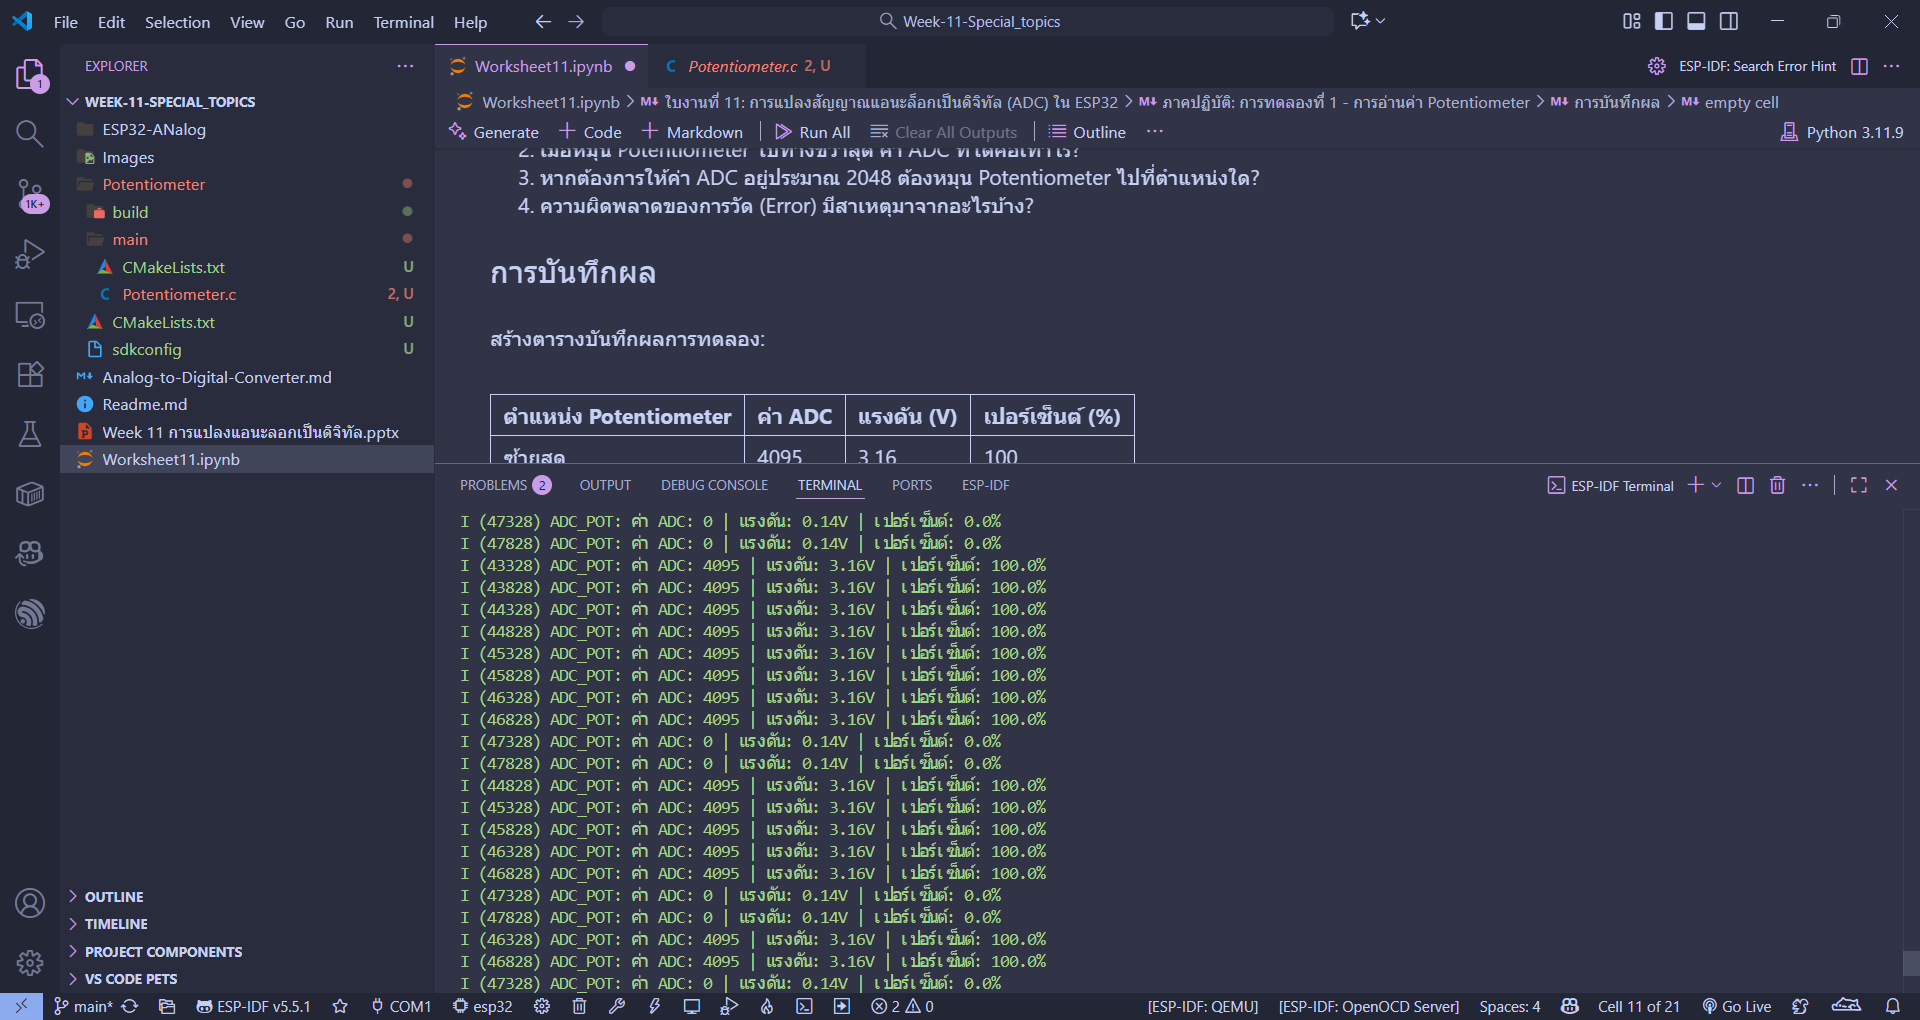

## การทดลองที่ 2 - การอ่านค่าเซนเซอร์แสง (LDR)

### วัตถุประสงค์
เพื่อศึกษาการใช้ ADC อ่านค่าจากเซนเซอร์ที่มีการเปลี่ยนแปลงตามสิ่งแวดล้อม

### วงจร
เชื่อมต่อ LDR กับ ESP32 ดังนี้


![](./Images/ESP32-LDR.png)


### หลักการทำงาน
- LDR เป็นตัวต้านทานที่เปลี่ยนค่าตามแสง
- เมื่อแสงมาก ความต้านทาน LDR ลดลง → แรงดันที่ ADC อ่านได้เพิ่มขึ้น
- เมื่อแสงน้อย ความต้านทาน LDR เพิ่มขึ้น → แรงดันที่ ADC อ่านได้ลดลง

In [ ]:
// การทดลองที่ 2: เซนเซอร์แสง LDR
// Light Sensor with ESP32 ADC using ESP-IDF

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/adc.h"
#include "esp_adc_cal.h"
#include "esp_log.h"

// กำหนด pin ที่ใช้
#define LDR_CHANNEL ADC1_CHANNEL_7  // GPIO35 (ADC1_CH7)
#define DEFAULT_VREF    1100        // ใช้ adc2_vref_to_gpio() เพื่อให้ได้ค่าประมาณที่ดีกว่า
#define NO_OF_SAMPLES   64          // การสุ่มสัญญาณหลายครั้ง

static const char *TAG = "ADC_LDR";
static esp_adc_cal_characteristics_t *adc_chars;

static bool check_efuse(void)
{
    // ตรวจสอบว่า TP ถูกเขียนลงใน eFuse หรือไม่
    if (esp_adc_cal_check_efuse(ESP_ADC_CAL_VAL_EFUSE_TP) == ESP_OK) {
        ESP_LOGI(TAG, "eFuse Two Point: รองรับ");
    } else {
        ESP_LOGI(TAG, "eFuse Two Point: ไม่รองรับ");
    }
    // ตรวจสอบว่า Vref ถูกเขียนลงใน eFuse หรือไม่
    if (esp_adc_cal_check_efuse(ESP_ADC_CAL_VAL_EFUSE_VREF) == ESP_OK) {
        ESP_LOGI(TAG, "eFuse Vref: รองรับ");
    } else {
        ESP_LOGI(TAG, "eFuse Vref: ไม่รองรับ");
    }
    return true;
}

static void print_char_val_type(esp_adc_cal_value_t val_type)
{
    if (val_type == ESP_ADC_CAL_VAL_EFUSE_TP) {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ Two Point Value");
    } else if (val_type == ESP_ADC_CAL_VAL_EFUSE_VREF) {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ eFuse Vref");
    } else {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ Default Vref");
    }
}

void app_main(void)
{
    // ตรวจสอบว่า Two Point หรือ Vref ถูกเขียนลงใน eFuse หรือไม่
    check_efuse();

    // กำหนดค่า ADC
    adc1_config_width(ADC_WIDTH_BIT_12);
    adc1_config_channel_atten(LDR_CHANNEL, ADC_ATTEN_DB_11);

    // ปรับเทียบ ADC
    adc_chars = calloc(1, sizeof(esp_adc_cal_characteristics_t));
    esp_adc_cal_value_t val_type = esp_adc_cal_characterize(ADC_UNIT_1, ADC_ATTEN_DB_11, ADC_WIDTH_BIT_12, DEFAULT_VREF, adc_chars);
    print_char_val_type(val_type);

    ESP_LOGI(TAG, "ทดสอบเซนเซอร์แสง LDR ของ ESP32");
    ESP_LOGI(TAG, "Pin: GPIO35 (ADC1_CH7)");
    ESP_LOGI(TAG, "ช่วง: 0-3.3V");
    ESP_LOGI(TAG, "ความละเอียด: 12-bit (0-4095)");
    ESP_LOGI(TAG, "Attenuation: 11dB");
    ESP_LOGI(TAG, "------------------------");

    // อ่านค่า ADC จาก LDR อย่างต่อเนื่อง
    while (1) {
        uint32_t adc_reading = 0;
        
        // การสุ่มสัญญาณหลายครั้ง
        for (int i = 0; i < NO_OF_SAMPLES; i++) {
            adc_reading += adc1_get_raw((adc1_channel_t)LDR_CHANNEL);
        }
        adc_reading /= NO_OF_SAMPLES;
        
        // แปลง adc_reading เป็นแรงดันในหน่วย mV
        uint32_t voltage_mv = esp_adc_cal_raw_to_voltage(adc_reading, adc_chars);
        float voltage = voltage_mv / 1000.0;
        
        // แปลงเป็นระดับแสง (สมมติ)
        float lightLevel = (adc_reading / 4095.0) * 100.0;
        
        // กำหนดสถานะแสง
        const char* lightStatus;
        if (lightLevel < 20) {
            lightStatus = "มืด";
        } else if (lightLevel < 50) {
            lightStatus = "แสงน้อย";
        } else if (lightLevel < 80) {
            lightStatus = "แสงปานกลาง";
        } else {
            lightStatus = "แสงจ้า";
        }
        
        // แสดงผลลัพธ์
        ESP_LOGI(TAG, "ADC: %d | แรงดัน: %.2fV | ระดับแสง: %.1f%% | สถานะ: %s", 
                 adc_reading, voltage, lightLevel, lightStatus);
        
        vTaskDelay(pdMS_TO_TICKS(1000));  // หน่วงเวลา 1 วินาที
    }
}

## การทดลองที่ 3 - การปรับปรุงความแม่นยำของ ADC

### วัตถุประสงค์
เพื่อศึกษาวิธีการปรับปรุงความแม่นยำของการอ่านค่า ADC ด้วยเทคนิคต่างๆ

### เทคนิคที่ใช้
1. **Oversampling**: การอ่านค่าหลายครั้งแล้วหาค่าเฉลี่ย
2. **Calibration**: การปรับค่า offset และ gain
3. **Filtering**: การกรองสัญญาณรบกวน

In [ ]:
// การทดลองที่ 3: ปรับปรุงความแม่นยำ ADC
// Enhanced ADC Reading with Oversampling and Filtering using ESP-IDF

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/adc.h"
#include "esp_adc_cal.h"
#include "esp_log.h"

// กำหนด pin และพารามิเตอร์
#define SENSOR_CHANNEL ADC1_CHANNEL_6  // GPIO34 (ADC1_CH6)
#define DEFAULT_VREF    1100           // ใช้ adc2_vref_to_gpio() เพื่อให้ได้ค่าประมาณที่ดีกว่า
#define OVERSAMPLES     100            // จำนวนครั้งในการ oversample
#define FILTER_SIZE     10             // ขนาดของ Moving Average Filter

static const char *TAG = "ADC_ENHANCED";
static esp_adc_cal_characteristics_t *adc_chars;

// ตัวแปรสำหรับ Moving Average Filter
static float filterBuffer[FILTER_SIZE];
static int filterIndex = 0;
static float filterSum = 0.0;
static bool filterInitialized = false;

static bool check_efuse(void)
{
    // ตรวจสอบว่า TP ถูกเขียนลงใน eFuse หรือไม่
    if (esp_adc_cal_check_efuse(ESP_ADC_CAL_VAL_EFUSE_TP) == ESP_OK) {
        ESP_LOGI(TAG, "eFuse Two Point: รองรับ");
    } else {
        ESP_LOGI(TAG, "eFuse Two Point: ไม่รองรับ");
    }
    // ตรวจสอบว่า Vref ถูกเขียนลงใน eFuse หรือไม่
    if (esp_adc_cal_check_efuse(ESP_ADC_CAL_VAL_EFUSE_VREF) == ESP_OK) {
        ESP_LOGI(TAG, "eFuse Vref: รองรับ");
    } else {
        ESP_LOGI(TAG, "eFuse Vref: ไม่รองรับ");
    }
    return true;
}

static void print_char_val_type(esp_adc_cal_value_t val_type)
{
    if (val_type == ESP_ADC_CAL_VAL_EFUSE_TP) {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ Two Point Value");
    } else if (val_type == ESP_ADC_CAL_VAL_EFUSE_VREF) {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ eFuse Vref");
    } else {
        ESP_LOGI(TAG, "ใช้การปรับเทียบแบบ Default Vref");
    }
}

// ฟังก์ชันอ่านค่าด้วย Oversampling
static float readADCOversampling(adc1_channel_t channel, int samples) 
{
    uint64_t sum = 0;
    for (int i = 0; i < samples; i++) {
        sum += adc1_get_raw(channel);
        vTaskDelay(pdMS_TO_TICKS(1));  // หน่วงเวลาเล็กน้อยระหว่างการอ่าน
    }
    return (float)sum / samples;
}

// ฟังก์ชัน Moving Average Filter
static float movingAverageFilter(float newValue) 
{
    if (!filterInitialized) {
        // เริ่มต้นตัวกรองครั้งแรก
        for (int i = 0; i < FILTER_SIZE; i++) {
            filterBuffer[i] = newValue;
        }
        filterSum = newValue * FILTER_SIZE;
        filterInitialized = true;
        return newValue;
    }
    
    // ลบค่าเก่าออกจาก sum
    filterSum -= filterBuffer[filterIndex];
    
    // เพิ่มค่าใหม่
    filterBuffer[filterIndex] = newValue;
    filterSum += newValue;
    
    // อัพเดท index
    filterIndex = (filterIndex + 1) % FILTER_SIZE;
    
    // คืนค่าเฉลี่ย
    return filterSum / FILTER_SIZE;
}

void app_main(void)
{
    // ตรวจสอบว่า Two Point หรือ Vref ถูกเขียนลงใน eFuse หรือไม่
    check_efuse();

    // กำหนดค่า ADC
    adc1_config_width(ADC_WIDTH_BIT_12);
    adc1_config_channel_atten(SENSOR_CHANNEL, ADC_ATTEN_DB_11);

    // ปรับเทียบ ADC
    adc_chars = calloc(1, sizeof(esp_adc_cal_characteristics_t));
    esp_adc_cal_value_t val_type = esp_adc_cal_characterize(ADC_UNIT_1, ADC_ATTEN_DB_11, ADC_WIDTH_BIT_12, DEFAULT_VREF, adc_chars);
    print_char_val_type(val_type);

    ESP_LOGI(TAG, "ทดสอบการปรับปรุงความแม่นยำ ADC");
    ESP_LOGI(TAG, "เทคนิค: Oversampling + Moving Average Filter");
    ESP_LOGI(TAG, "Pin: GPIO34 (ADC1_CH6)");
    ESP_LOGI(TAG, "Oversamples: %d, Filter Size: %d", OVERSAMPLES, FILTER_SIZE);
    ESP_LOGI(TAG, "----------------------------------------");

    // อ่านค่า ADC อย่างต่อเนื่องด้วยเทคนิคต่างๆ
    while (1) {
        // อ่านค่าแบบปกติ (ครั้งเดียว)
        uint32_t rawValue = adc1_get_raw(SENSOR_CHANNEL);
        
        // อ่านค่าด้วย Oversampling
        float oversampledValue = readADCOversampling(SENSOR_CHANNEL, OVERSAMPLES);
        
        // ผ่านตัวกรอง Moving Average
        float filteredValue = movingAverageFilter(oversampledValue);
        
        // แปลงเป็นแรงดันด้วย calibration
        uint32_t raw_voltage_mv = esp_adc_cal_raw_to_voltage(rawValue, adc_chars);
        uint32_t oversampled_voltage_mv = esp_adc_cal_raw_to_voltage((uint32_t)oversampledValue, adc_chars);
        uint32_t filtered_voltage_mv = esp_adc_cal_raw_to_voltage((uint32_t)filteredValue, adc_chars);
        
        float rawVoltage = raw_voltage_mv / 1000.0;
        float oversampledVoltage = oversampled_voltage_mv / 1000.0;
        float filteredVoltage = filtered_voltage_mv / 1000.0;
        
        // แสดงผลเปรียบเทียบ
        ESP_LOGI(TAG, "=== การเปรียบเทียบ ===");
        ESP_LOGI(TAG, "Raw ADC: %d (%.3fV)", rawValue, rawVoltage);
        ESP_LOGI(TAG, "Oversampled: %.1f (%.3fV)", oversampledValue, oversampledVoltage);
        ESP_LOGI(TAG, "Filtered: %.1f (%.3fV)", filteredValue, filteredVoltage);
        ESP_LOGI(TAG, "");
        
        vTaskDelay(pdMS_TO_TICKS(2000));  // หน่วงเวลา 2 วินาที
    }
}

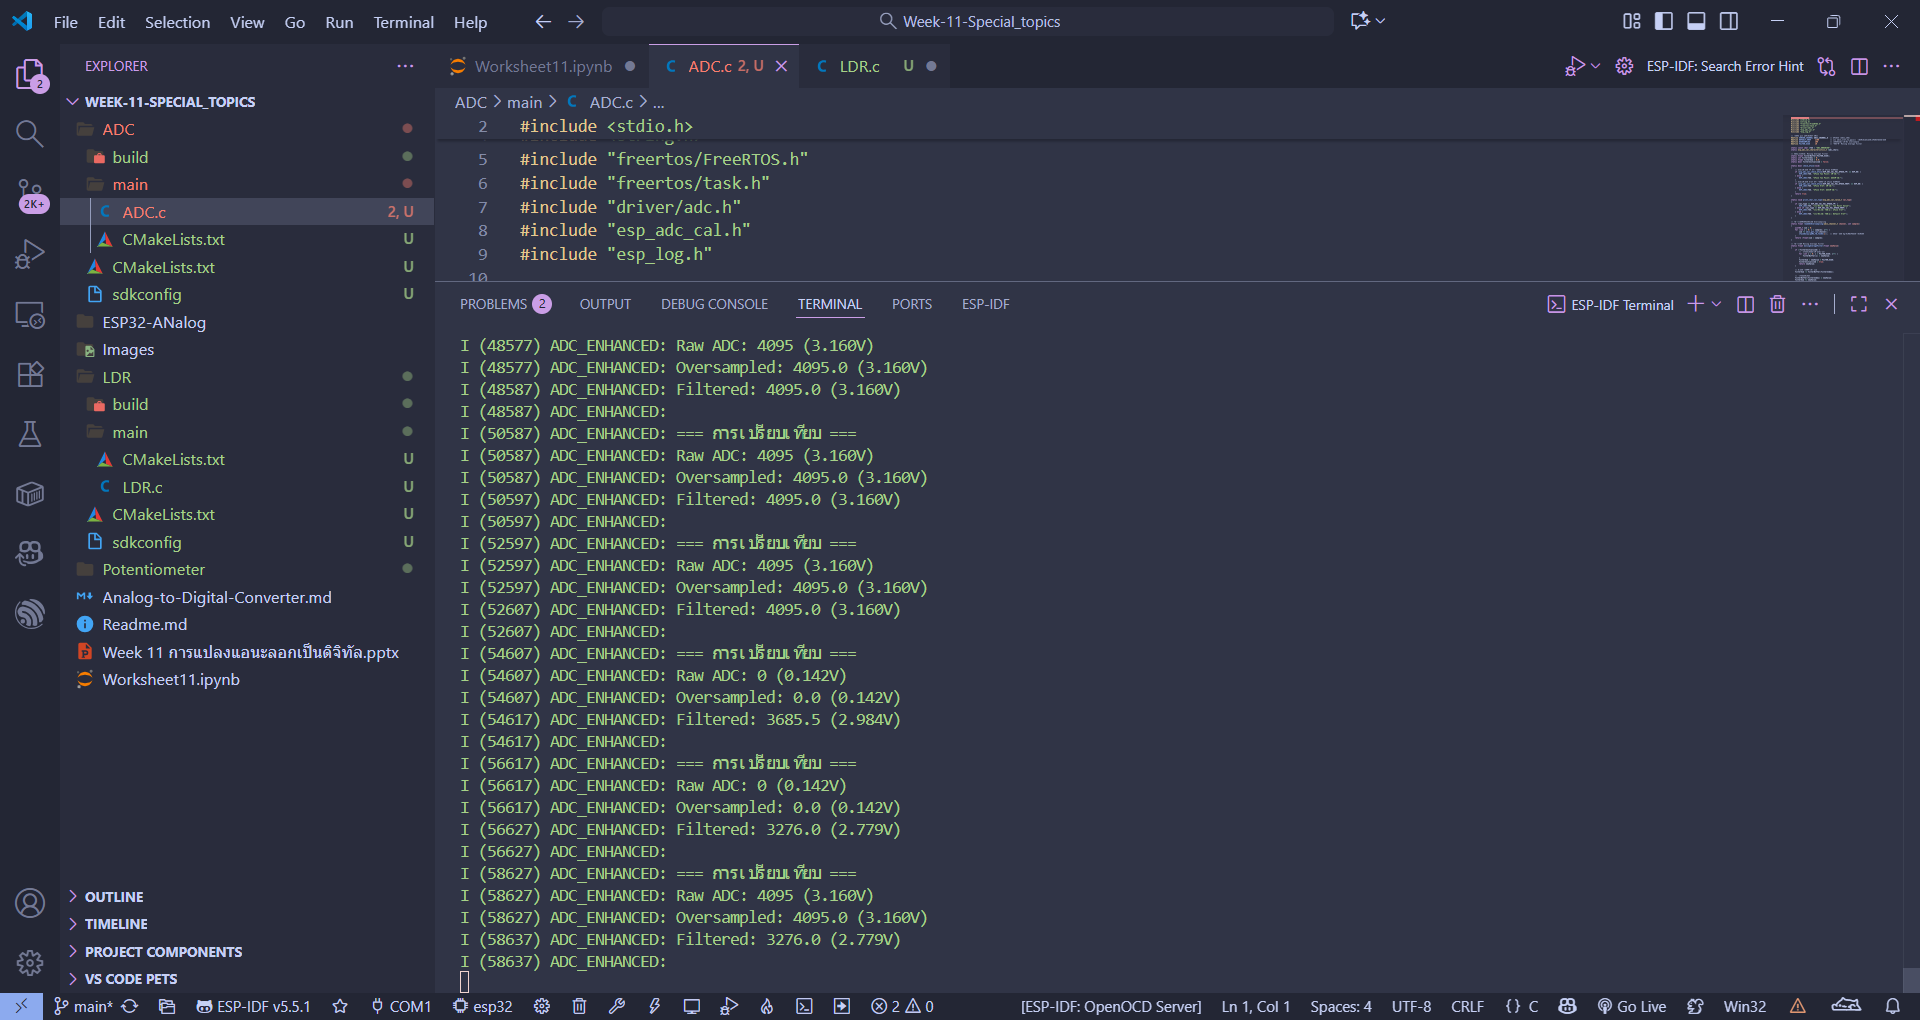

## โจทย์ท้าทาย 

1. ออกแบบระบบควบคุมแสง LED โดยใช้ค่าจาก LDR


### วงจรที่ใช้

![](./Images/ESP32-LDR-LED.png) 

### การทำงาน 
- เมื่อแสงน้อยให้หรี่ LED เพื่อไม่ให้แสงจ้าเกินไป
- เมื่อแสงมากให้เพิ่มความสว่างของ LED เพื่อให้สู้แสงภายนอกได้

2. สร้างระบบเตือนเมื่อค่าเซนเซอร์เกินขีดจำกัด

### วงจรที่ใช้

![](./Images/ESP32-LDR-BUZZER.png)

###  การทำงาน 
- เมื่อแสงน้อยกว่าเกณฑ์ที่ตั้งไว้ (เช่น ค่าที่อ่านได้น้อยกว่า 1000) ให้ Buzzer ดังเตือน

### เพิ่มเติม 
- อาจจะเพิ่ม LED แล้วสั่งให้ติดสว่างขึ้นเพื่อแสดงสถานะว่า LDR ยังคงทำงานอยู่

## การวิเคราะห์ผลและแบบฝึกหัด

### คำถามท้าทาย
1. **การคำนวณความละเอียด**: 
   - ADC 12-bit มีความละเอียดเท่าไร? (ในหน่วย mV เมื่อใช้ช่วง 0-3.3V)
   - หากต้องการความละเอียด 1mV ต้องใช้ ADC กี่บิต?

2. **การวิเคราะห์ error**:
   - Quantization error สูงสุดของ 12-bit ADC คือเท่าไร?
   - เหตุใดการใช้ oversampling จึงช่วยลด noise ได้?

